In [9]:
# Step 0: Install required Python packages and libraries.
# Depends on what libraries you need, but for example:
# !pip install openpyxl

In [10]:
# Step 1: Import required libraries
import numpy as np  # Scientific computing in Python
import pandas as pd # Data structure
from PIL import Image # Converting images into arrays
import matplotlib as mpl # Visualization library
import matplotlib.pyplot as plt # Plotting
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # Word Cloud and Stop Words
import urllib # URL handling
from openpyxl import Workbook # Required for reading and writing Excel files

In [11]:
# Step 2: Save mask of Canada to image_mask. Image mask defines the shape.
image_mask = np.array(Image.open(urllib.request.urlopen('https://github.com/untej/Canada-Immigration-Word-Cloud/blob/main/Canada_image_mask_all_red_with_white_background.png?raw=true')))
# Note 2024-05-23: Image color mask can be used to define a particular color scheme for an image mask.
# For example, if each province in the image mask was colored a different color, then words in the word cloud could be colored to match the color of the province they are placed on top of.
# It is important to note that this does not convey extra meaning. For example, if Alberta were colored blue, the words the word cloud lays on top of Alberta would be colored blue but may
# not have any specific significance to Alberta. I.e. In this 'Immigration to Canada' word cloud, if 'Ukraine' were colored blue and sitting on top of Alberta, that does not mean that 
# most of Alberta's immigrants are Ukrainians. So use of a color mask should be carefully considered to ensure no incorrect assumptions in meaning are inferred by the viewer.
# Secondly, in word clouds like this one, where a particular word might dominate the word cloud, the coloring of the output word cloud may not be visually appealing. This is because all
# of a single word like 'China' will inherit one color from the color map, but may span over multiple color areas. Word cloud color maps are best used when there are a lot of words for
# the word cloud and they are all relatively equally weighted with no true behemoths to dominate the output image.
# We leave this code here as something to be experimented further with at a later date, if necessary.
image_color_mask = image_mask

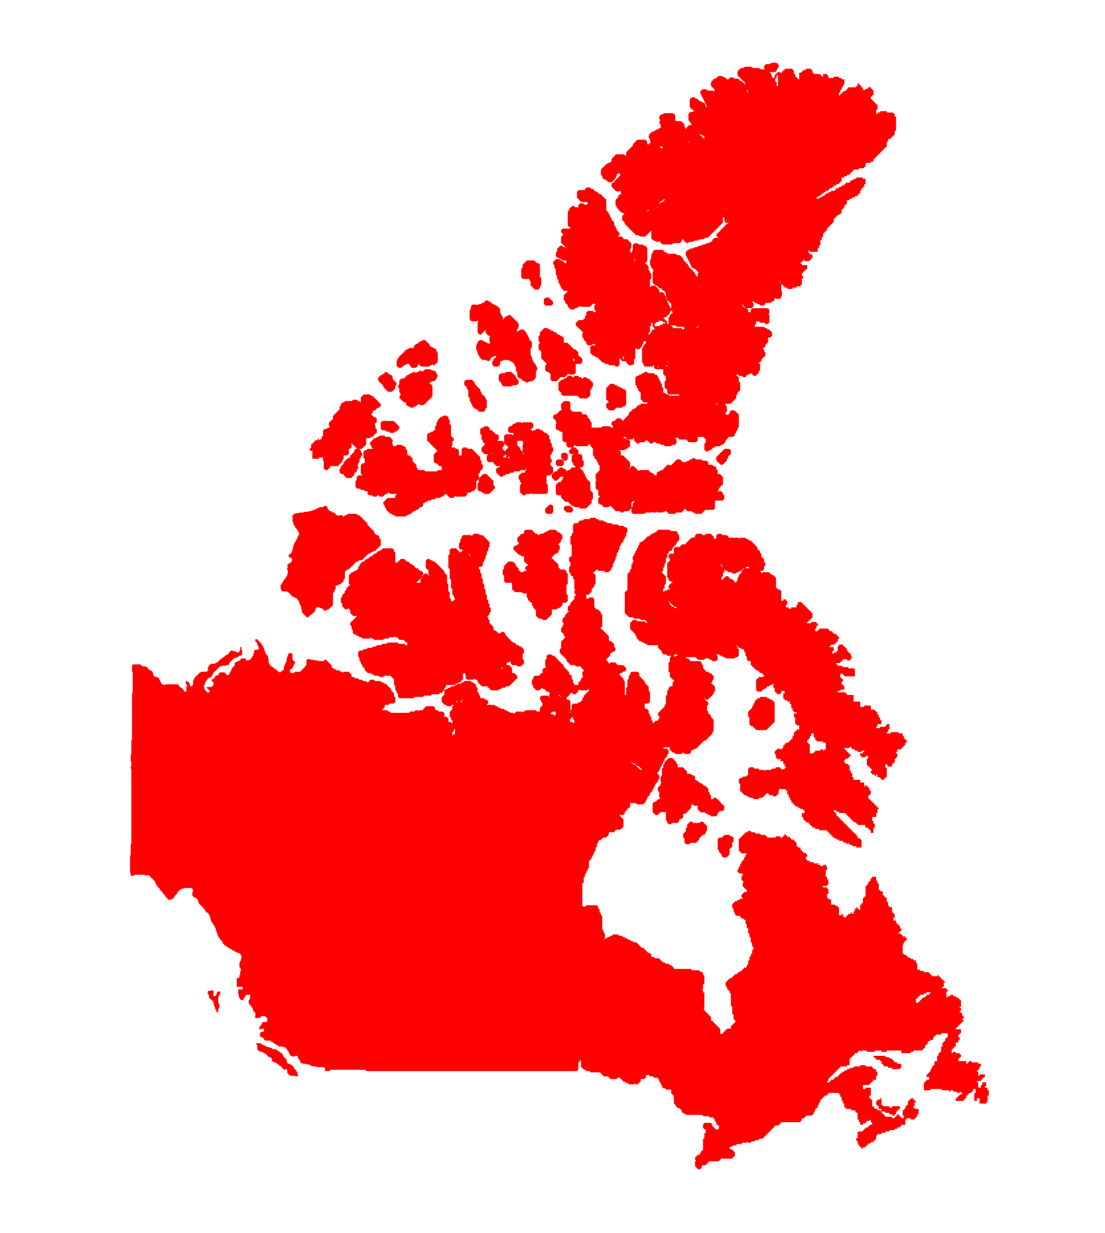

In [12]:
# Preview how the image mask looks.
fig = plt.figure(figsize=(14, 18))

plt.imshow(image_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis('off')
plt.show()

In [13]:
# Step 3: Define Stopwords.
# Author's note: Stopwords are common words that are not of interest, and that you do not want shown in your word cloud.
# In this project we do not use any stopwords, as we are not visualizing textual data.
# But if you wanted to use stopwords, this would be how you would do it.

# Declare stopwords variable. Use set() function to remove any redundant stopwords.
#stopwords = set(STOPWORDS)

# Add words to the stop words
#stopwords.add('said') # Add the word 'said' to the list of stopwords

In [14]:
# Step 4: Prepare a dataframe for analysis.

df_can = pd.read_excel(
    'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DV0101EN/labs/Data_Files/Canada.xlsx',
    sheet_name="Canada by Citizenship",
    skiprows=range(20),
    skipfooter=2
)

# Drop unnecessary columns
# axis = 0 represents rows (default), axis = 1 represents columns
# Column names are case sensitive
df_can.drop(['AREA','REG','DEV','Type','Coverage'], axis=1, inplace=True)

# Rename remaining columns
df_can.rename(columns={'OdName':'Country','AreaName':'Continent','RegName':'Region'}, inplace=True)

# Add column 'Total'
df_can['Total'] = df_can.sum(axis=1, numeric_only=True)

# Set index column
df_can.set_index('Country', inplace=True)

# Sort dataframe based on Total column
df_can.sort_values(['Total'], ascending=False, axis=0, inplace=True)

# Note 2023-12-01: I ran into the KeyError: "None of ['Country'] are in the columns"
# when trying to update country names via the replace method below.
# Reseting the index makes 'Country' a column in the data set and allows us to
# perform this operation.
df_can.reset_index(inplace=True)

In [15]:
# Note 2023-12-01: The original approach as taught in the DV0101EN Cognitive Class course requires that Country names must be single words for purposes of analysis.
# Thus, countries need to be renamed and shortened into single words. Where a single word option is not available, an underscore can replace the spaces between words.
# Note 2024-05-13: I ran into a FutureWarning.
# FutureWarning: "A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
# The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.""
# The solution to this is to create a separate object that will not trigger the warning, replace on the new object/column, and then assign the modified column back to the original dataframe.

# Create a copy of the 'Country' column
country_copy = df_can['Country'].copy()

# Replace values in the copied column
country_copy.replace({'United Kingdom of Great Britain and Northern Ireland':'UK',
                           'United States of America':'USA',
                           'Russian Federation':'Russia',
                           'Democratic Republic of the Congo':'DRC',
                           # Author's Note: Congo is already the name of once country in this data set
                           # As a result, we cannot short name this country 'Congo' because then it will create
                           # duplicate instances of this name. Instead we name this country 'DRC.'
                           # If there are duplicate instances of a country name in the dataset, when you 
                           # attempt to create the word cloud you will get a 'TypeError: Cannot convert series to class int'
                           # This is because Python tries to feed both values which have the same key (e.g. Congo)
                           # as a series into the function int() which must take a single value to convert that value to integer.
                           'United Republic of Tanzania':'Tanzania',
                           'Czech Republic':'Czechia',
                           'United Arab Emirates':'UAE',
                           'Central African Republic':'Ubangi Shari',
                           'China, Macao Special Administrative Region':'Macao',
                           'Iran (Islamic Republic of)':'Iran',
                           'Syrian Arab Republic':'Syria',
                           'Republic of Korea':'South Korea',
                           "Democratic People's Republic of Korea":"North Korea",
                           'Venezuela (Bolivarian Republic of)':'Venezuela',
                           'Bolivia (Plurinational State of)':'Bolivia',
                           'Brunei Darussalam':'Brunei',
                           "Côte d'Ivoire":'Ivory Coast',
                           'Viet Nam':'Vietnam',
                           "Lao People's Democratic Republic":"Laos",
                           'State of Palestine':'Palestine',
                           'Republic of Moldova':'Moldova',
                           'The former Yugoslav Republic of Macedonia':'Macedonia'
                           }, inplace=True)

# Assign the modified column back to the original DataFrame
df_can['Country'] = country_copy

# Preview our dataset.
df_can.head()


,Country,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
0,India,Asia,Southern Asia,Developing regions,8880,8670,8147,7338,5704,4211,...,36210,33848,28742,28261,29456,34235,27509,30933,33087,691904
1,China,Asia,Eastern Asia,Developing regions,5123,6682,3308,1863,1527,1816,...,42584,33518,27642,30037,29622,30391,28502,33024,34129,659962
2,UK,Europe,Northern Europe,Developed regions,22045,24796,20620,10015,10170,9564,...,7258,7140,8216,8979,8876,8724,6204,6195,5827,551500
3,Philippines,Asia,South-Eastern Asia,Developing regions,6051,5921,5249,4562,3801,3150,...,18139,18400,19837,24887,28573,38617,36765,34315,29544,511391
4,Pakistan,Asia,Southern Asia,Developing regions,978,972,1201,900,668,514,...,14314,13127,10124,8994,7217,6811,7468,11227,12603,241600


In [16]:
# Step 5: Create a dictionary of country names with the total immigration from 1980 to 2013
# Note 2024-05-14: Special thanks to Ruslan Saiko's comment on Stackoverflow on 3 December 2019 who gave me the idea to use a dictionary to create the wordcloud,
# instead of the complex logic taught in the Cognitive Class DV0101EN course. Cognitive Class teaches you to calculate the ratio of immigrants to Canada per country,
# and then multiple that ratio by a fixed maximum number of words for the word cloud.
# The dictionary approach is so much simpler, and has substantially reduced my lines of code. Most imporantly, the dictionary approach allows for spaces in your word cloud words.
# So for example, "South Korea" stays "South Korea" instead of becoming "South" and "Korea" seperately. This is important since a large number of South African and South Korean immigrants
# would result in a large "South" word in the word cloud with smaller "Korea" and "Africa" words, and no true understanding of what proportion of immigrants are coming from either of those
# respective countries. Check out the Stackoverflow post here: https://stackoverflow.com/questions/59148244/keeping-words-together-in-wordcloud

country_dict = df_can.set_index('Country')['Total'].to_dict()

print(country_dict)

{'India': 691904, 'China': 659962, 'UK': 551500, 'Philippines': 511391, 'Pakistan': 241600, 'USA': 241122, 'Iran': 175923, 'Sri Lanka': 148358, 'South Korea': 142581, 'Poland': 139241, 'Lebanon': 115359, 'France': 109091, 'Jamaica': 106431, 'Vietnam': 97146, 'Romania': 93585, 'Haiti': 84813, 'Guyana': 75785, 'Portugal': 74167, 'Egypt': 72745, 'Morocco': 72267, 'Colombia': 72088, 'Iraq': 69789, 'Algeria': 69439, 'Israel': 66508, 'Bangladesh': 65568, 'Germany': 63912, 'Russia': 63344, 'Mexico': 58712, 'Afghanistan': 58639, 'El Salvador': 54878, 'Ukraine': 51410, 'Trinidad and Tobago': 50016, 'Somalia': 42109, 'South Africa': 40568, 'Nigeria': 39732, 'Jordan': 35406, 'Ethiopia': 35136, 'Peru': 32652, 'Turkey': 31781, 'Syria': 31485, 'Brazil': 29659, 'Japan': 27707, 'Netherlands': 26884, 'Ghana': 26032, 'DRC': 25582, 'Malaysia': 24417, 'Australia': 23829, 'Bulgaria': 23310, 'Italy': 22624, 'Bosnia and Herzegovina': 21855, 'Chile': 21359, 'Venezuela': 21267, 'Fiji': 20609, 'Cuba': 20365, 'A

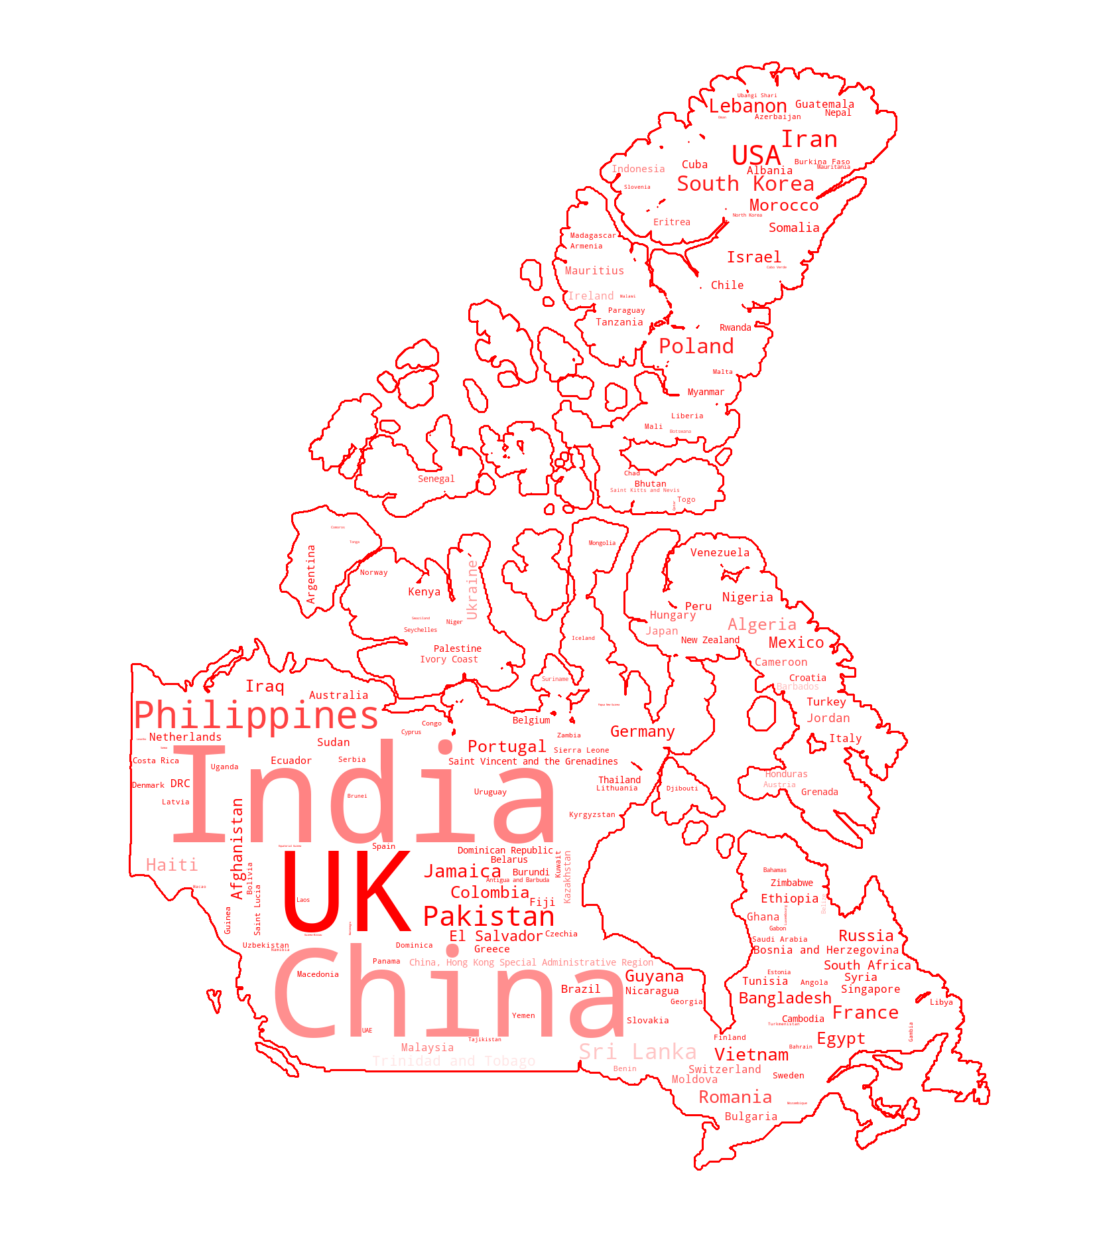

In [18]:
# Step 6: Create word cloud of Immigration to Canada, where the size of the country's name is proportional
# to the number of immigrants from that of origin country to Canada.

# Note 2024-05-14: Documentation of WordCloud library provides method for colouring the text so as to match the original image.
# https://amueller.github.io/word_cloud/auto_examples/colored.html#sphx-glr-auto-examples-colored-py
# Create colouring from image
image_colors = ImageColorGenerator(image_color_mask)

# Instantiate a word cloud object
canada_wordcloud = WordCloud(
    background_color='white', #'white' 'gray'
    #max_words=2000,
    mask=image_mask,
    # Author's note: The original code included stopword parameters. In this case, there are no stopwords,
    # so I have commented out this line of code. But left it in here as a reference for how you could exclude
    # stopwords from your word cloud visual.
    #, stopwords=stopwords
    # Author's note: Modified original code by adding contour parameters
    # based on A. Mueller's documentation found here:
    # https://amueller.github.io/word_cloud/auto_examples/masked.html#sphx-glr-auto-examples-masked-py
    contour_width=3,
    contour_color='red',
    # Author's note: Words are not supposed to be repeated by default, but I found them to be repeated,
    # so have explicitly declared that words should not be repeated. Based on A. Mueller's documentation found here:
    # https://amueller.github.io/word_cloud/cli.html
    repeat=False,
    # Author's note: However, even after setting repeat to False, Country names still repeat (e.g. 'India India').
    # thanks to craigching who posted on Stackedoverflow on 14 July 2017 that the setting to turn off repeating
    # words in your word cloud is called collocations.
    # https://stackoverflow.com/questions/43954114/python-wordcloud-repetitive-words
    collocations=False,
    color_func=image_colors # Can be passed either directly in the constructor (here), or in imshow() like .imshow(color_func=image_colors)
)

# Generate the word cloud
canada_wordcloud.generate_from_frequencies(country_dict)

# Display the word cloud
fig = plt.figure(figsize=(14, 18))

plt.imshow(canada_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Export image to file
canada_wordcloud.to_file("immigration_to_canada_wordcloud.png")